# Final Project Aviation Dataset

In [9]:
# Load Libraries here
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pyLDAvis
import pyLDAvis.lda_model
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/edgarrosales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/edgarrosales/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/edgarrosales/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/edgarrosales/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Dataset

In [2]:
# Load the CSV (adjust path if needed)
df = pd.read_csv("data/ASRS_DBOnline.csv")

## Clean, Tokenize & Normalize

In [3]:
# 2.1 Drop any empty narratives
df = df.dropna(subset=['Report 1'])

# 2.2 Lower-case all text
df['clean_text'] = df['Report 1'].str.lower()

# 2.3 Remove everything except letters & spaces
df['clean_text'] = df['clean_text'].str.replace(r'[^a-z\s]', ' ', regex=True)

# 2.4 Tokenize by splitting on whitespace
df['tokens'] = df['clean_text'].str.split()

# 2.5 Remove stop words and 1-letter tokens
stop = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(
    lambda toks: [t for t in toks if t not in stop and len(t) > 1]
)

# 2.6 Lemmatize for normalization
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(
    lambda toks: [lemmatizer.lemmatize(t) for t in toks]
)

In [4]:
df[['Report 1','clean_text','tokens']].head()

,Report 1,clean_text,tokens
0,Narrative,narrative,[narrative]
1,Was told to line up and wait runway XXR at int...,was told to line up and wait runway xxr at int...,"[told, line, wait, runway, xxr, intersection, ..."
2,A large corporate aircraft taxied with in 5-8 ...,a large corporate aircraft taxied with in ...,"[large, corporate, aircraft, taxied, inch, sta..."
3,GPS Spoofing. Enroute today from ZZZ to SOF; w...,gps spoofing enroute today from zzz to sof w...,"[gps, spoofing, enroute, today, zzz, sof, nort..."
4,Practicing simulated arcs with instrument stud...,practicing simulated arcs with instrument stud...,"[practicing, simulated, arc, instrument, stude..."


## Exploratory Data Analysis

Assessments.1
Human Factors                               2055
Aircraft                                    1751
Weather                                      218
ATC Equipment / Nav Facility / Buildings      70
Environment - Non Weather Related             67
Staffing                                       2
Primary Problem                                1
Name: count, dtype: int64


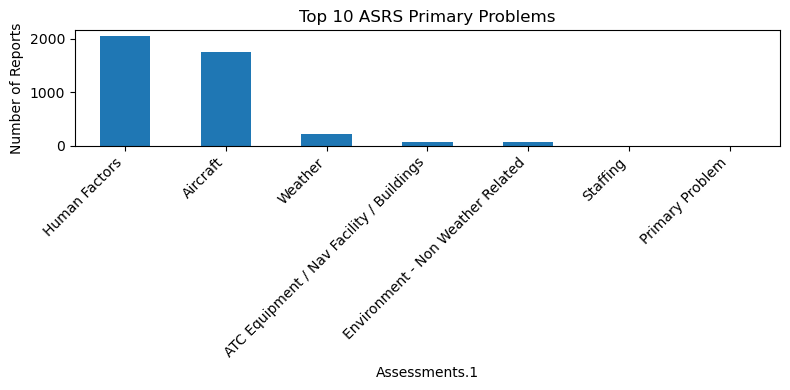

In [5]:
# Count how many reports per problem category
label_counts = df['Assessments.1'].value_counts()

# Display top 10
print(label_counts.head(10))

# Bar plot of top 10
label_counts.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 ASRS Primary Problems")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Human Factors and Aircraft account for nearly 90% of the reports.

count    4164.000000
mean      123.274015
std       104.814701
min         1.000000
25%        57.000000
50%        95.000000
75%       157.000000
max      1102.000000
Name: token_count, dtype: float64


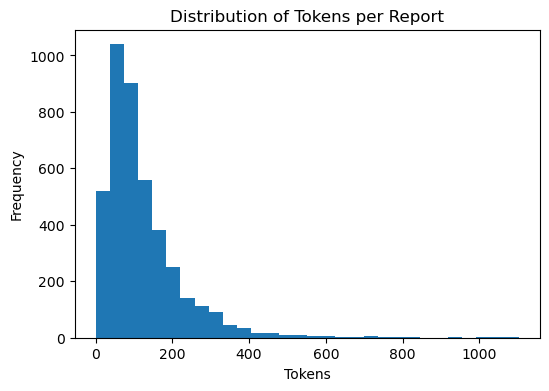

In [6]:
# Compute token counts
df['token_count'] = df['tokens'].map(len)

print(df['token_count'].describe())

df['token_count'].plot(kind='hist', bins=30, figsize=(6,4))
plt.title("Distribution of Tokens per Report")
plt.xlabel("Tokens")
plt.show()

Narratives average about 123 Tokens with a majority falling between 60 and 160 words. This makes sense as radio communications should be "short and sweet". 

             freq
aircraft     9395
zzz          6799
runway       5553
flight       5346
approach     3781
landing      3547
u            3482
engine       3459
time         2868
back         2814
pilot        2797
would        2519
left         2443
altitude     2413
right        2323
atc          2257
control      2187
airport      2084
captain      1932
maintenance  1905


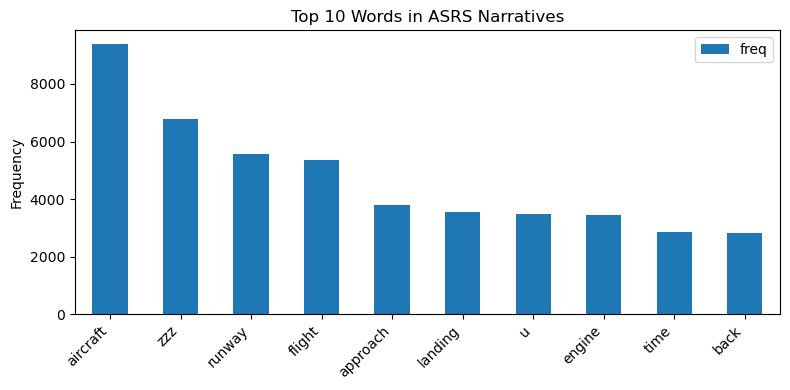

In [7]:
# Flatten all tokens into one list and count
all_counts = Counter()
df['tokens'].map(all_counts.update)

# Convert to DataFrame
freq_df = (
    pd.DataFrame.from_dict(all_counts, orient='index', columns=['freq'])
      .sort_values('freq', ascending=False)
)

# Show top 20
print(freq_df.head(20))

# Plot top 10
freq_df.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 Words in ASRS Narratives")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

ZZZ suggests further cleaning. Aircraft, Runway, Flight, Approach reflect reports consisting of routine aircraft operations and runway interactions. 

# Create Features and Labels - 

### Use preprocessed tokens to create features and use Assessments.1 as the label; build feature words based on frequency

In [8]:
# Build feature words based on frequency
word_cutoff = 5
tokens = [t for tokens in df['tokens'] for t in tokens]
word_dist = FreqDist(tokens)

feature_words = set()
for word, count in word_dist.items():
    if count >= word_cutoff:
        feature_words.add(word)

### Define feature extraction function

In [9]:
def conv_features(text, fw):
    """Convert text to feature dictionary for NLTK Naive Bayes"""
    text_set = set(text.split())
    text_set = text_set.intersection(fw)
    return {word: True for word in text_set}

### Clean data and build feature sets

In [10]:
# Ensure there are no nulls in tokens
df = df.dropna(subset=['tokens'])

# Join token list into a single string
df['joined_tokens'] = df['tokens'].apply(lambda x: ' '.join(x))

# Convert joined tokens into feature sets
featuresets = [
    (conv_features(text, feature_words), label)
    for text, label in zip(df['joined_tokens'], df['Assessments.1'])
]

# Naive Bayes
### Train/Test Split and train Naive Bayes Classifier

In [11]:
import random
random.seed(42)
random.shuffle(featuresets)

test_size = 500
test_set = featuresets[:test_size]
train_set = featuresets[test_size:]

classifier = nltk.NaiveBayesClassifier.train(train_set)

In [12]:
# Accuracy
print("Naive Bayes Accuracy:", nltk.classify.accuracy(classifier, test_set))

# Most informative features
classifier.show_most_informative_features(10)

Naive Bayes Accuracy: 0.006
Most Informative Features
                creating = True           Staffi : Aircra =    852.2 : 1.0
                division = True           Staffi : Human  =    606.3 : 1.0
              procedural = True           Staffi : Human  =    606.3 : 1.0
                 staffed = True           Staffi : Human  =    606.3 : 1.0
                  uneven = True           Staffi : Human  =    606.3 : 1.0
                shortcut = True           Staffi : Aircra =    511.3 : 1.0
             supervision = True           Staffi : Aircra =    511.3 : 1.0
               narrative = True           Primar : Human  =    389.8 : 1.0
                   angry = True           Staffi : Aircra =    306.8 : 1.0
                 handoff = True           Staffi : Aircra =    306.8 : 1.0


##### Based on the accuracy, Naive Bayes fails to generalize and likely predicts only the most common class or guesses randomly.


### Predict and Compare with actual labels

In [13]:
# Try a few predictions
for i in range(5):
    print(f"Report: {df.iloc[i]['joined_tokens'][:120]}...")
    predicted = classifier.classify(conv_features(df.iloc[i]['joined_tokens'], feature_words))
    actual = df.iloc[i]['Assessments.1']
    print(f"Predicted: {predicted} | Actual: {actual}\n")

Report: narrative...
Predicted: Human Factors | Actual: Primary Problem

Report: told line wait runway xxr intersection cleared take passing kt pic pilot flying rejected takeoff due tow crossing approa...
Predicted: Primary Problem | Actual: Human Factors

Report: large corporate aircraft taxied inch static parked helicopter monitoring ramp situation lack corporate pilot awareness t...
Predicted: Primary Problem | Actual: Human Factors

Report: gps spoofing enroute today zzz sof north egypt approaching lakto intersection filed route ipads showed airplane directly...
Predicted: Primary Problem | Actual: ATC Equipment / Nav Facility / Buildings

Report: practicing simulated arc instrument student aircraft came directly u altitude descended turned avoid aircraft followed c...
Predicted: Primary Problem | Actual: Human Factors



# Logistic Regression
### Vectorize text with TF-IDF

In [14]:
# Filter out rare labels (keep only labels with >= 5 samples)
label_counts = df['Assessments.1'].value_counts()
valid_labels = label_counts[label_counts >= 5].index
df_filtered = df[df['Assessments.1'].isin(valid_labels)].copy()

# Prepare features and labels
X = df_filtered['joined_tokens']
y = df_filtered['Assessments.1']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, stratify=y, random_state=42
)

### Train Logistic Regression

In [15]:
# Train a Logistic Regression classifier on the TF-IDF features
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.8703481392557023
                                          precision    recall  f1-score   support

ATC Equipment / Nav Facility / Buildings       0.25      0.07      0.11        14
                                Aircraft       0.88      0.90      0.89       351
       Environment - Non Weather Related       0.00      0.00      0.00        13
                           Human Factors       0.87      0.95      0.91       411
                                 Weather       0.95      0.43      0.59        44

                                accuracy                           0.87       833
                               macro avg       0.59      0.47      0.50       833
                            weighted avg       0.85      0.87      0.85       833



##### The LR model performs well on the categories of Aircraft and Human Factors, but does not perform well on under-represented classes like the Environment-Non Weather and ATC Equipment / Nav Facility / Buildings. Weather has high precision and low recall which means the model is selective/cautious when predicting Weather and will predict it only when it is confident. 

### Determine Most Informative Features

In [16]:
# Extract feature names and model coefficients for interpretation
feature_names = vectorizer.get_feature_names_out()
coefs = lr.coef_

# For multiclass — loop through classes
for idx, class_label in enumerate(lr.classes_):
    top_features = np.argsort(coefs[idx])[-10:]  # Top 10
    print(f"\nTop features for class: {class_label}")
    for feat in reversed(top_features):
        print(f"{feature_names[feat]:>15} : {coefs[idx][feat]:.3f}")


Top features for class: ATC Equipment / Nav Facility / Buildings
            gps : 2.273
      frequency : 1.544
         sector : 1.500
            rnp : 1.096
             il : 1.034
     glideslope : 1.000
          radio : 0.975
     controller : 0.960
            tag : 0.793
       position : 0.738

Top features for class: Aircraft
         engine : 3.342
            zzz : 2.651
    maintenance : 2.306
            qrh : 2.088
        failure : 1.951
           gear : 1.946
       priority : 1.740
       pressure : 1.731
          cabin : 1.717
         normal : 1.695

Top features for class: Environment - Non Weather Related
            gps : 2.314
           bird : 2.154
       spoofing : 1.193
        terrain : 1.175
         strike : 0.931
        spoofed : 0.903
        jamming : 0.784
         object : 0.704
            mud : 0.690
         relief : 0.683

Top features for class: Human Factors
          drone : 2.004
        traffic : 1.625
            bag : 1.487
          

### Predict and Compare with actual labels

In [17]:
# Predict and display results for 5 random sample reports
sample_texts = df['joined_tokens'].sample(5, random_state=42)

for text in sample_texts:
    X_sample = vectorizer.transform([text])
    pred = lr.predict(X_sample)[0]
    print(f"Text: {text[:100]}...\nPredicted: {pred}\n")

Text: normal takeoff rwy xx zzz climbing around msl student reduced power maximum continuous load required...
Predicted: Aircraft

Text: midfield crossing flying parallel rwy xx parallel heading near miss company aircraft discussed fligh...
Predicted: Human Factors

Text: base given heading join short time later speed knot asked airport instructed clear visual shortly al...
Predicted: Human Factors

Text: single engine piston plane night vfr lost electrical system landed nearest airport largest well lit ...
Predicted: Aircraft

Text: previously launched aircraft heading runway followed clearing aircraft takeoff runway heading cleari...
Predicted: Human Factors



# Support Vector Machine

In [18]:
# Train the SVM model
svm = LinearSVC()
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.8787515006002401

Classification Report:
                                          precision    recall  f1-score   support

ATC Equipment / Nav Facility / Buildings       0.29      0.14      0.19        14
                                Aircraft       0.89      0.91      0.90       351
       Environment - Non Weather Related       0.50      0.15      0.24        13
                           Human Factors       0.88      0.94      0.91       411
                                 Weather       0.96      0.55      0.70        44

                                accuracy                           0.88       833
                               macro avg       0.70      0.54      0.59       833
                            weighted avg       0.87      0.88      0.87       833



##### The SVM model performs similarly well also on the categories of Aircraft and Human Factors and not well to under-represented classes like the Environment-Non Weather and ATC Equipment / Nav Facility / Buildings. Weather has high precision and low recall which means the model is selective/cautious when predicting Weather and will predict it only when it is confident. SVM is a stronger classfier if maximizing accuracy and handling minority classes.

### Determine Most informative features - SVM

In [19]:
# Extract feature names and model coefficients for interpretation
feature_names = vectorizer.get_feature_names_out()
coefs = svm.coef_

# For multiclass — loop through classes
for idx, class_label in enumerate(svm.classes_):
    top10 = np.argsort(coefs[idx])[-10:]
    print(f"\nTop features for class: {class_label}")
    for feat_index in reversed(top10):
        print(f"{feature_names[feat_index]:>15} : {coefs[idx][feat_index]:.3f}")



Top features for class: ATC Equipment / Nav Facility / Buildings
         sector : 1.029
            bgr : 1.024
            rnp : 1.004
     glideslope : 0.996
            cpr : 0.951
            tag : 0.916
            sbn : 0.909
        goggles : 0.862
             il : 0.860
       position : 0.830

Top features for class: Aircraft
        failure : 2.053
         engine : 1.990
            qrh : 1.697
            rpm : 1.606
       pressure : 1.555
            zzz : 1.508
    maintenance : 1.505
        problem : 1.463
          issue : 1.416
           fail : 1.367

Top features for class: Environment - Non Weather Related
           bird : 1.487
        spoofed : 1.317
       spoofing : 1.116
            mud : 1.086
          cairo : 1.055
            gps : 0.882
            orl : 0.813
     electronic : 0.808
        terrain : 0.799
      eastbound : 0.798

Top features for class: Human Factors
          drone : 1.597
     distracted : 1.556
            set : 1.538
          

# Topic Modeling 

In [10]:
#load CSV
df = pd.read_csv("data/ASRS_DBOnline.csv")

#drop missing reports
df = df.dropna(subset=['Report 1'])

#preprocessing setup
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#preprocess and build joined_tokens
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

df['joined_tokens'] = df['Report 1'].apply(clean_text)

In [11]:

vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['joined_tokens'])


### Non-negative Matrix Funcation Model

In [12]:
#number of topics
num_topics = 10

#fit the NMF model
nmf_model = NMF(n_components=num_topics, random_state=42)
W = nmf_model.fit_transform(X_tfidf) 
H = nmf_model.components_             


In [18]:
def display_topics(model, feature_names, top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx:5d}")
        top_indices = topic.argsort()[::-1][:top_words]
        for i in top_indices:
            print(f"{feature_names[i]} ({topic[i]:.2f})")
        print()


display_topics(nmf_model, vectorizer.get_feature_names_out())


Topic     0
zzz (1.03)
captain (0.85)
flight (0.77)
maintenance (0.72)
qrh (0.63)
cabin (0.63)
checklist (0.62)
passenger (0.59)
gate (0.56)
dispatch (0.55)

Topic     1
aircraft (1.14)
runway (0.96)
traffic (0.66)
pattern (0.59)
downwind (0.47)
call (0.39)
student (0.39)
xx (0.34)
left (0.33)
radio (0.33)

Topic     2
approach (1.61)
visual (0.58)
altitude (0.52)
terrain (0.45)
cleared (0.40)
final (0.38)
ft (0.35)
tower (0.34)
zzzzz (0.31)
low (0.31)

Topic     3
brake (1.73)
parking (0.75)
tug (0.55)
set (0.55)
push (0.50)
crew (0.41)
aircraft (0.40)
ramp (0.38)
taxiway (0.37)
ground (0.35)

Topic     4
gear (2.14)
landing (0.66)
nose (0.42)
runway (0.36)
main (0.36)
light (0.32)
flap (0.25)
locked (0.24)
extension (0.22)
green (0.22)

Topic     5
engine (2.35)
power (0.64)
oil (0.57)
zzz (0.33)
runway (0.33)
rpm (0.31)
takeoff (0.28)
checklist (0.27)
normal (0.24)
landing (0.24)

Topic     6
dg (1.91)
dangerous (0.83)
good (0.70)
summary (0.57)
final (0.55)
received (0.50)
acars (0

### Latent Semantic Analysis

In [19]:
#number of topics
num_topics = 10

#fit LSA model
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_model.fit(X_tfidf)

#topic-word matrix
H_lsa = lsa_model.components_


In [20]:
def display_topics(model, feature_names, top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx:02d}")
        top_indices = topic.argsort()[::-1][:top_words]
        for i in top_indices:
            print(f"{feature_names[i]} ({topic[i]:.2f})")
        print()


display_topics(lsa_model, vectorizer.get_feature_names_out())


Topic 00
aircraft (0.26)
runway (0.21)
zzz (0.21)
engine (0.16)
approach (0.15)
flight (0.14)
landing (0.13)
pilot (0.11)
left (0.10)
altitude (0.10)

Topic 01
engine (0.30)
zzz (0.16)
checklist (0.14)
maintenance (0.13)
captain (0.12)
qrh (0.11)
fuel (0.11)
gate (0.10)
crew (0.10)
dispatch (0.09)

Topic 02
approach (0.35)
altitude (0.26)
ft (0.16)
atc (0.14)
terrain (0.12)
visual (0.12)
descent (0.11)
zzzzz (0.10)
autopilot (0.09)
alert (0.09)

Topic 03
engine (0.41)
runway (0.16)
power (0.15)
fuel (0.14)
zzz (0.13)
oil (0.11)
landing (0.10)
student (0.08)
rpm (0.08)
tank (0.07)

Topic 04
gear (0.43)
brake (0.23)
approach (0.21)
runway (0.17)
landing (0.14)
nose (0.11)
taxiway (0.11)
flap (0.10)
speed (0.09)
set (0.08)

Topic 05
gear (0.44)
landing (0.17)
dg (0.14)
zzz (0.12)
runway (0.12)
door (0.10)
pattern (0.10)
message (0.09)
qrh (0.09)
dispatch (0.08)

Topic 06
dg (0.43)
approach (0.26)
engine (0.23)
final (0.23)
runway (0.22)
dangerous (0.17)
good (0.14)
summary (0.13)
received

### Latent Dirichlet Allocation 

In [31]:
#CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)
count_text_vectors = count_vectorizer.fit_transform(df['joined_tokens'])

#fit LDA model using count-based vectors
lda_model = LatentDirichletAllocation(
    n_components=5, 
    random_state=42, 
    learning_method='batch'
)
lda_model.fit(count_text_vectors)

LatentDirichletAllocation(n_components=5, random_state=42)

In [33]:
#display_topics on fitted model
display_topics(lda_model, count_vectorizer.get_feature_names_out())


Topic 00
aircraft (4676.38)
runway (2715.04)
traffic (1736.48)
pattern (1046.14)
zzz (1018.94)
tower (985.56)
pilot (944.54)
left (903.63)
turn (876.40)
call (874.83)

Topic 01
aircraft (1784.49)
brake (1487.88)
gear (929.33)
runway (891.52)
taxiway (767.13)
taxi (702.35)
ramp (684.78)
gate (657.02)
back (637.54)
ground (628.80)

Topic 02
zzz (2632.36)
flight (2342.64)
maintenance (1497.28)
aircraft (1397.90)
captain (1308.00)
landing (1295.28)
checklist (1115.56)
control (1012.03)
passenger (1011.59)
would (974.30)

Topic 03
engine (3144.42)
zzz (1690.25)
fuel (1089.76)
power (1003.40)
runway (929.92)
landing (814.43)
flight (707.49)
aircraft (600.06)
back (541.26)
oil (529.74)

Topic 04
approach (2873.09)
altitude (1693.94)
atc (1099.81)
zzz (1071.76)
aircraft (937.16)
ft (924.71)
flight (892.51)
time (702.57)
pilot (686.12)
visual (682.21)



In [32]:
#visualize with pyLDAvis
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.lda_model.prepare(
    lda_model, 
    count_text_vectors, 
    count_vectorizer, 
    sort_topics=False
)
lda_display

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.120463  0.049081       1        1  22.181604
1     -0.067743  0.145750       2        1  16.082568
2     -0.079585 -0.059228       3        1  27.498054
3     -0.086655 -0.073142       4        1  13.170960
4      0.113521 -0.062461       5        1  21.066814, topic_info=          Term         Freq        Total Category  logprob  loglift
1513    engine  3457.000000  3457.000000  Default  30.0000  30.0000
284   approach  3755.000000  3755.000000  Default  29.0000  29.0000
565      brake  1556.000000  1556.000000  Default  28.0000  28.0000
4526   traffic  1835.000000  1835.000000  Default  27.0000  27.0000
1881      fuel  1372.000000  1372.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1749     final   480.275764  1569.784286   Topic5  -5.3820   0.3731
3794    runway   630.187779  5520.327469   Topic5  -5.1104  -0.6127
4599      turn   470.890499  1721.583827   Topic5  -5.4018   0.2611
4932     would   453.687158  2493.349763   Topic5  -5.4390  -0.1465
2457   landing   424.361947  3513.937274   Topic5  -5.5058  -0.5564

[405 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
58        2  0.971456  acknowledgement
58        5  0.017043  acknowledgement
60        2  0.964165   acknowledgment
60        3  0.029217   acknowledgment
82        1  0.819236               ad
...     ...       ...              ...
4997      4  0.033196             zzzz
4997      5  0.099588             zzzz
4998      3  0.122629            zzzzz
4998      4  0.007432            zzzzz
4998      5  0.869550            zzzzz

[879 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])